# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is d:\Work_Stuff\PhD\Fair_Universe\Repositories\HEP-Challenge



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799808 entries, 0 to 799807
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 85.4 MB
None
[+] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
train_visualize = Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 799808
[*] --- Number of features : 28
   diboson   40590.0
   htautau   3638.999999999999
   ttbar   158761.0
   ztautau   3605618.0000000056
[*] --- Number of signal events : 764
[*] --- Number of background events : 799044
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,32.490799,-0.288199,0.894572,53.228199,-0.209148,-2.380160,53.228199,-0.209148,-2.380160,-25.0,...,20.460157,-25.0,-25.0,-25.0,3.009492,63.501667,138.947205,0.610406,-1.413433,-25.0
1,55.797699,-0.204729,-3.015010,42.801201,0.294167,-0.269948,42.801201,0.294167,-0.269948,-25.0,...,13.444165,-25.0,-25.0,-25.0,2.790029,32.183971,141.400101,1.303648,-1.414210,-25.0
2,23.382200,0.109785,-2.803420,33.688000,-1.426980,0.562222,33.688000,-1.426980,0.562222,-25.0,...,4.497922,-25.0,-25.0,-25.0,3.297530,29.650312,90.758202,0.694081,-1.391188,-25.0
3,23.575500,-0.966310,0.359187,30.080400,-1.363730,-2.812360,30.080400,-1.363730,-2.812360,-25.0,...,3.617960,-25.0,-25.0,-25.0,3.136915,26.462595,83.736298,0.783750,-1.394096,-25.0
4,31.612301,-0.034575,-2.319390,35.279701,-0.086411,0.814609,35.279701,-0.086411,0.814609,-25.0,...,20.504530,-25.0,-25.0,-25.0,3.134428,55.753555,102.171700,0.896048,1.412329,-25.0


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,...,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000
mean,31.260996,-0.000525,0.002528,38.804180,-0.000783,-0.000535,46.889645,-0.001276,-0.001369,-0.414199,...,29.910397,-15.135414,36.670757,-15.415766,2.834053,46.305222,141.076355,0.868364,0.156098,-15.566597
std,14.859568,1.254476,1.813899,15.610263,1.275478,1.814803,31.262815,1.368178,1.814102,35.140553,...,37.678585,12.837393,115.527336,12.542912,0.539713,24.271912,91.909782,0.425987,1.255030,12.259123
min,20.000000,-2.500150,-3.141590,22.909500,-2.691050,-3.141590,22.909500,-4.825600,-3.141590,-25.000000,...,0.018948,-25.000000,-25.000000,-25.000000,0.565101,0.018135,66.035301,0.035373,-1.414214,-25.000000
25%,23.367300,-0.989745,-1.568055,29.618099,-1.016960,-1.573370,31.537500,-1.052470,-1.574055,-25.000000,...,9.241993,-25.000000,-25.000000,-25.000000,2.688978,32.944573,93.936972,0.616958,-1.381724,-25.000000
50%,27.605499,-0.000481,0.003372,35.832001,-0.001451,-0.004209,38.615398,-0.005103,-0.003370,-25.000000,...,17.055353,-25.000000,-25.000000,-25.000000,3.011937,42.731085,113.005253,0.786117,0.807241,-25.000000
75%,33.965500,0.989518,1.573043,43.480825,1.018432,1.575200,48.224499,1.052783,1.569482,28.563999,...,33.438220,0.792736,76.848705,-0.093061,3.142372,54.391516,146.387802,1.004764,1.391444,0.019528
max,914.013000,2.499990,3.141590,729.056030,2.692490,3.141590,1487.359985,4.892340,3.141590,790.189026,...,1287.277954,8.439010,4404.101074,20.012760,5.710185,1000.972290,2671.584961,15.351994,1.414214,1.000000


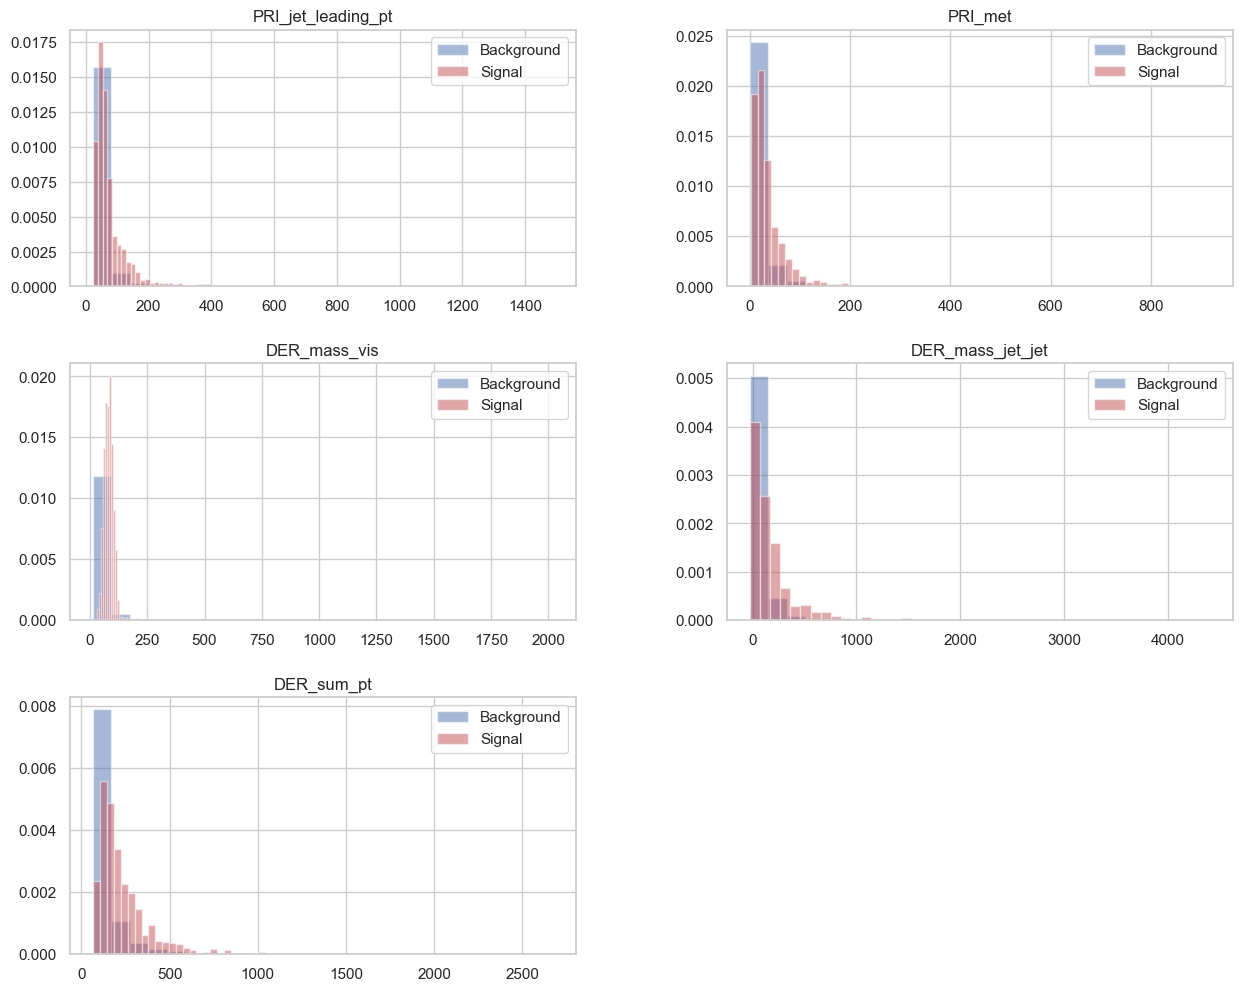

In [15]:
# Show data summary
train_visualize.histogram_dataset()

diboson (8524,)
diboson (8524,)
htautau (30,)
ttbar (33340,)
ttbar (33340,)
ztautau (757180,)
ztautau (757180,)


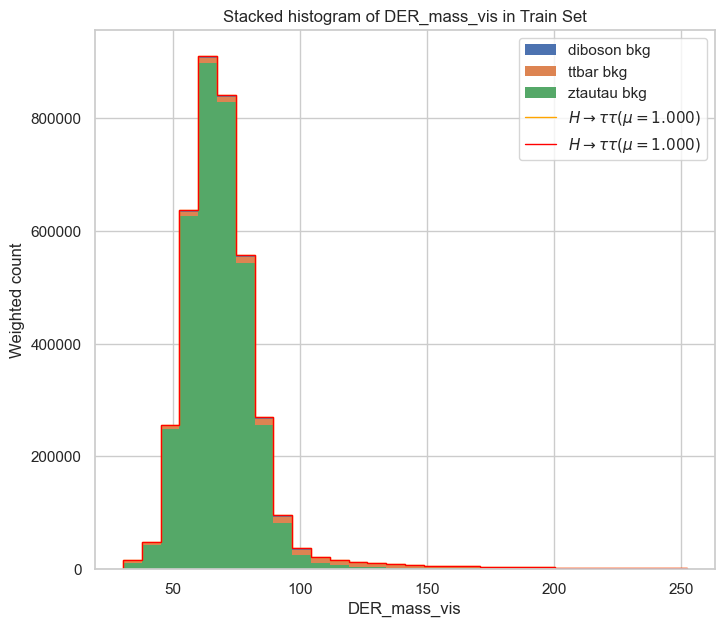

In [16]:
train_visualize.stacked_histogram("DER_mass_vis")

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [ ]:
syst_train_data = data.get_syst_train_set()

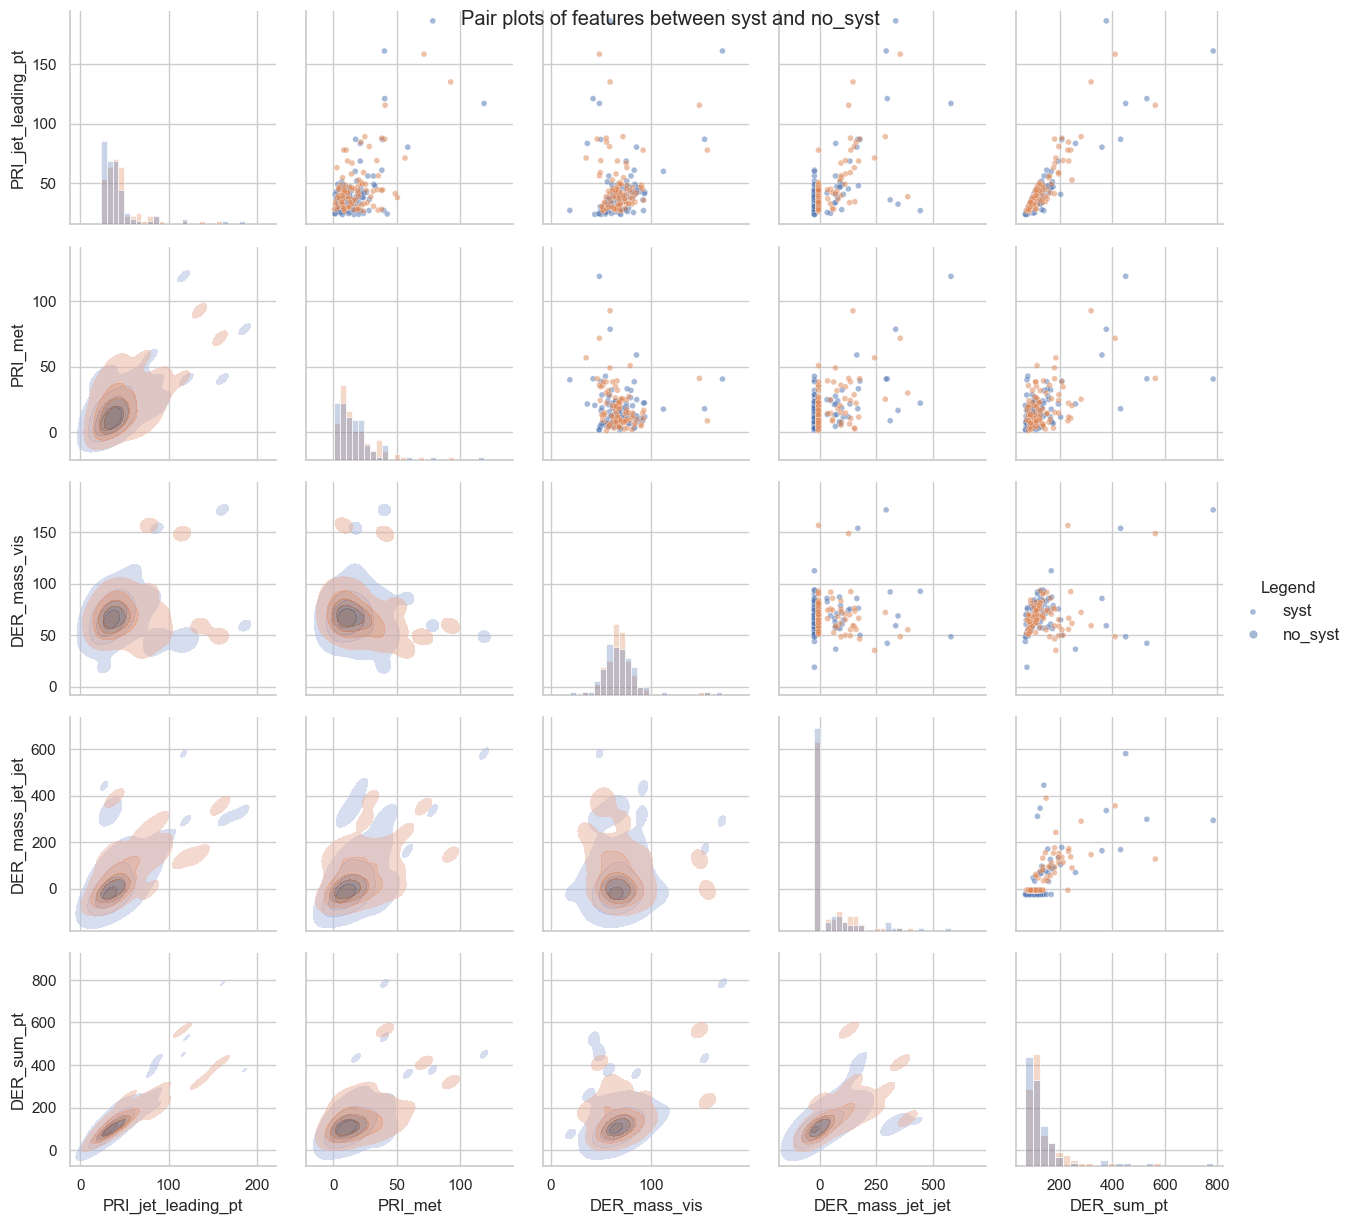

In [ ]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [ ]:
bootstraped_data = data.generate_psuedo_exp_data()

In [ ]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 799808
[*] --- Number of features : 28
   diboson   40590.0
   htautau   3638.999999999999
   ttbar   158761.0
   ztautau   3605618.0000000056
[*] --- Number of signal events : 764
[*] --- Number of background events : 799044
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,32.490799,-0.288199,0.894572,53.228199,-0.209148,-2.380160,53.228199,-0.209148,-2.380160,-25.0,...,20.460157,-25.0,-25.0,-25.0,3.009492,63.501667,138.947205,0.610406,-1.413433,-25.0
1,55.797699,-0.204729,-3.015010,42.801201,0.294167,-0.269948,42.801201,0.294167,-0.269948,-25.0,...,13.444165,-25.0,-25.0,-25.0,2.790029,32.183971,141.400101,1.303648,-1.414210,-25.0
2,23.382200,0.109785,-2.803420,33.688000,-1.426980,0.562222,33.688000,-1.426980,0.562222,-25.0,...,4.497922,-25.0,-25.0,-25.0,3.297530,29.650312,90.758202,0.694081,-1.391188,-25.0
3,23.575500,-0.966310,0.359187,30.080400,-1.363730,-2.812360,30.080400,-1.363730,-2.812360,-25.0,...,3.617960,-25.0,-25.0,-25.0,3.136915,26.462595,83.736298,0.783750,-1.394096,-25.0
4,31.612301,-0.034575,-2.319390,35.279701,-0.086411,0.814609,35.279701,-0.086411,0.814609,-25.0,...,20.504530,-25.0,-25.0,-25.0,3.134428,55.753555,102.171700,0.896048,1.412329,-25.0


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,...,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000,799808.000000
mean,31.260996,-0.000525,0.002528,38.804180,-0.000783,-0.000535,46.889645,-0.001276,-0.001369,-0.414199,...,29.910397,-15.135414,36.670757,-15.415766,2.834053,46.305222,141.076355,0.868364,0.156098,-15.566597
std,14.859568,1.254476,1.813899,15.610263,1.275478,1.814803,31.262815,1.368178,1.814102,35.140553,...,37.678585,12.837393,115.527336,12.542912,0.539713,24.271912,91.909782,0.425987,1.255030,12.259123
min,20.000000,-2.500150,-3.141590,22.909500,-2.691050,-3.141590,22.909500,-4.825600,-3.141590,-25.000000,...,0.018948,-25.000000,-25.000000,-25.000000,0.565101,0.018135,66.035301,0.035373,-1.414214,-25.000000
25%,23.367300,-0.989745,-1.568055,29.618099,-1.016960,-1.573370,31.537500,-1.052470,-1.574055,-25.000000,...,9.241993,-25.000000,-25.000000,-25.000000,2.688978,32.944573,93.936972,0.616958,-1.381724,-25.000000
50%,27.605499,-0.000481,0.003372,35.832001,-0.001451,-0.004209,38.615398,-0.005103,-0.003370,-25.000000,...,17.055353,-25.000000,-25.000000,-25.000000,3.011937,42.731085,113.005253,0.786117,0.807241,-25.000000
75%,33.965500,0.989518,1.573043,43.480825,1.018432,1.575200,48.224499,1.052783,1.569482,28.563999,...,33.438220,0.792736,76.848705,-0.093061,3.142372,54.391516,146.387802,1.004764,1.391444,0.019528
max,914.013000,2.499990,3.141590,729.056030,2.692490,3.141590,1487.359985,4.892340,3.141590,790.189026,...,1287.277954,8.439010,4404.101074,20.012760,5.710185,1000.972290,2671.584961,15.351994,1.414214,1.000000


In [ ]:
print("sum of weights = ", (bootstraped_data["weights"]).sum())

sum of weights =  3214511.0


***
### Program
***


In [ ]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [ ]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799808 entries, 0 to 799807
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 85.4 MB
None
[+] Train data loaded successfully
Full data:  (799808, 28)
Full Labels:  (799808,)
Full Weights:  (799808,)
sum_signal_weights:  3638.999999999999
sum_bkg_weights:  3804968.999999998
 
 
Full size of the data is 799808
Train size is 484958
Test size is 399904
Full size of the data is 399904
Train size is 242425
Test size is 199952
Training Set:
-------- 
  Data Shape:          (484958, 28)
  Labels Shape:        (484958,)
  Weights Shape:       (484958,)
  Sum Signal Weights:  2171.97
  Sum Background Weights: 2307150.91


Validation Set:
---------- 
  Data Shape:          (242425, 28)
  Labels Shape:        (242425,)
  Weights Shape:       (242425,)
  Sum Signal Weights:  1038.35
  Sum Background Weights: 1153365.93


Holdout (For Statistical Templa

[*] Calling fit method of submitted model
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.813e+07                 │              Nfcn = 856              │
│ EDM = 0.042 (Goal: 0.0001)       │            time = 1.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────┬───────────┬───────────┬─

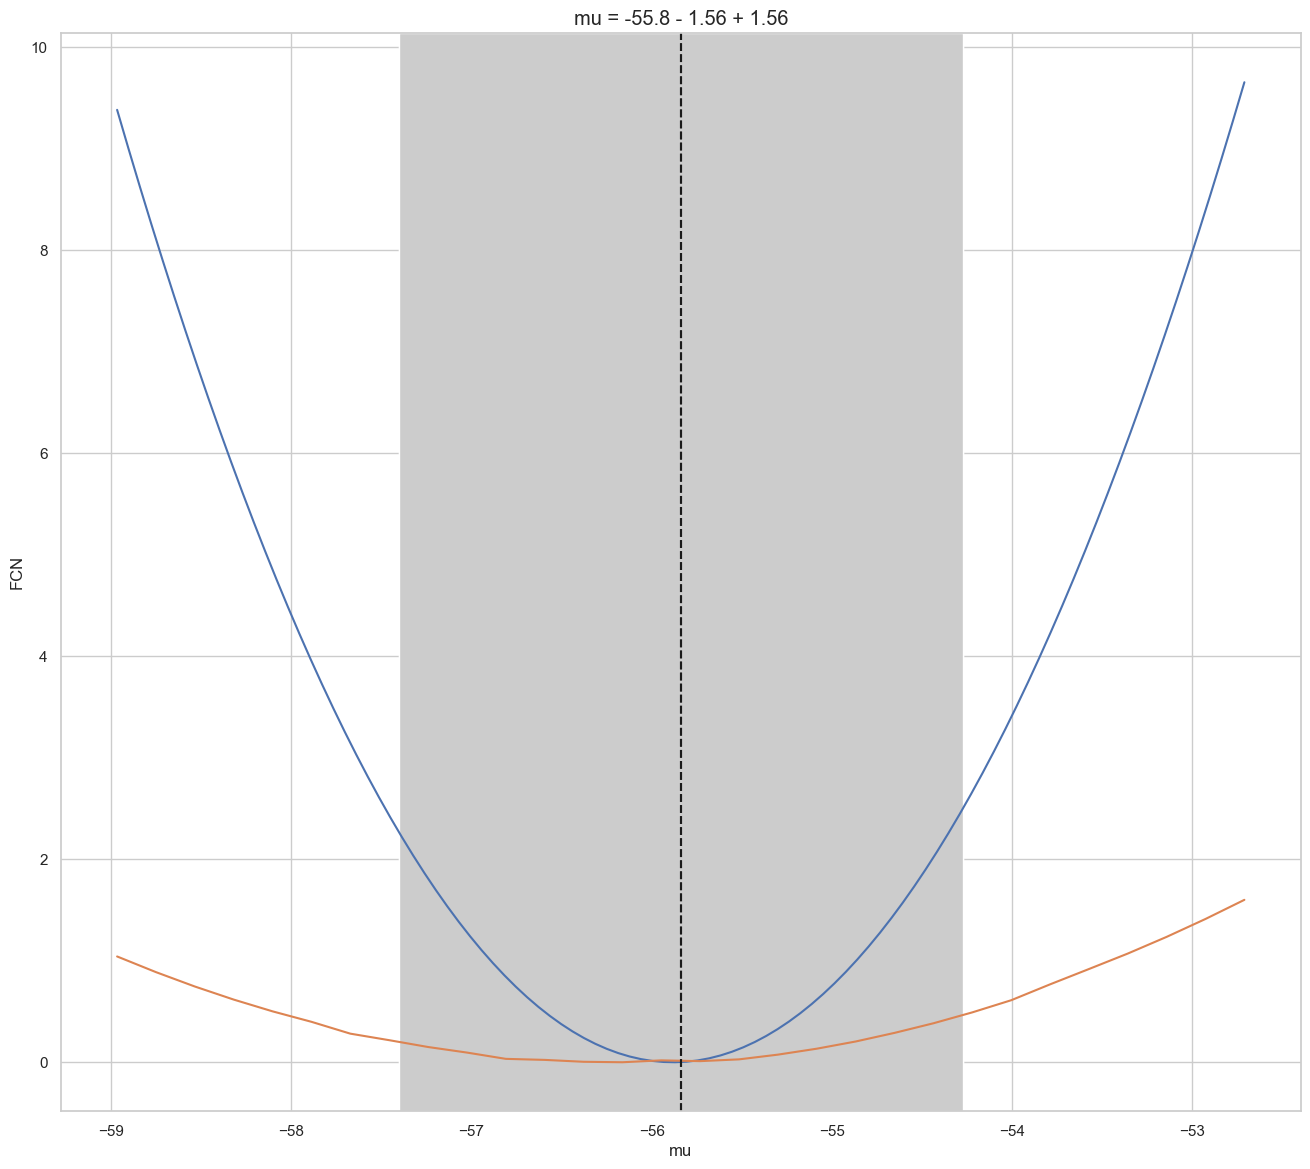

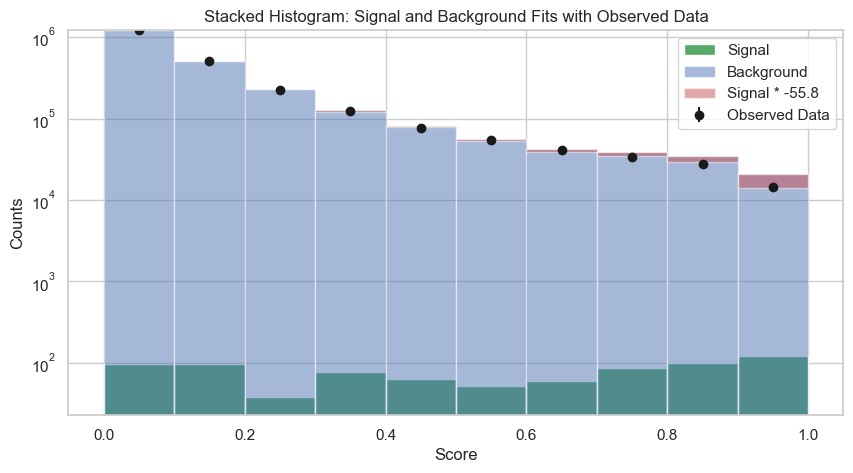

Training Results:
-------- Results:
	mu_hat : -55.83906008108516
	delta_mu_hat : 3.1269774725946258
	p16 : -57.402548817382474
	p84 : -54.27557134478784


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.326e+07                 │              Nfcn = 767              │
│ EDM = 0.0727 (Goal: 0.0001)      │            time = 2.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└────────

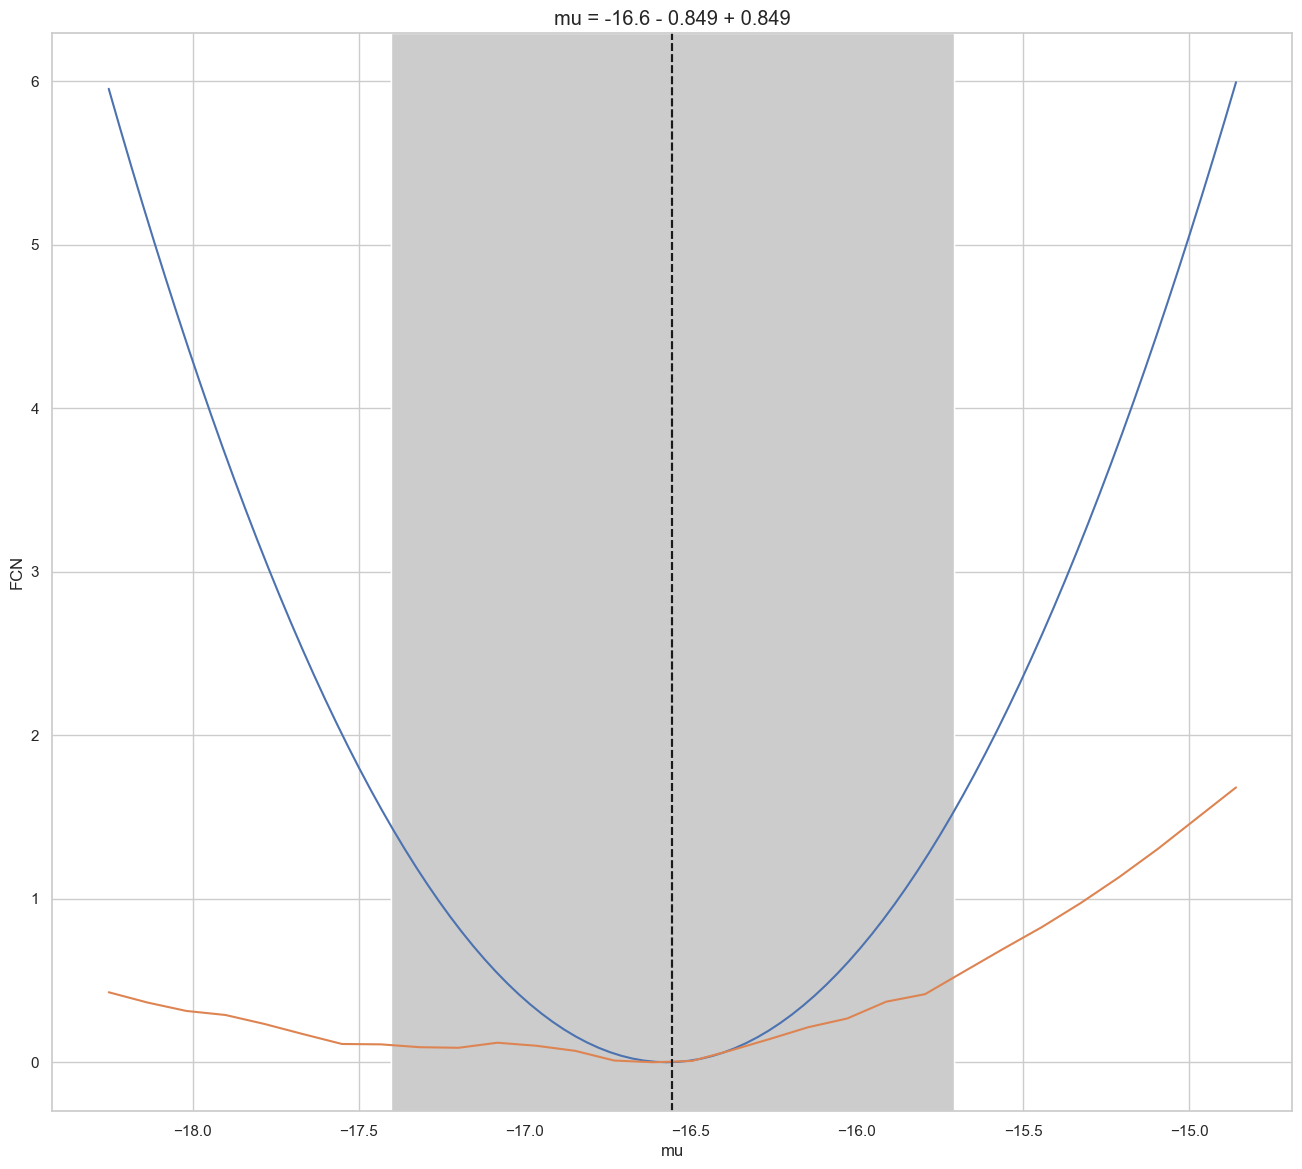

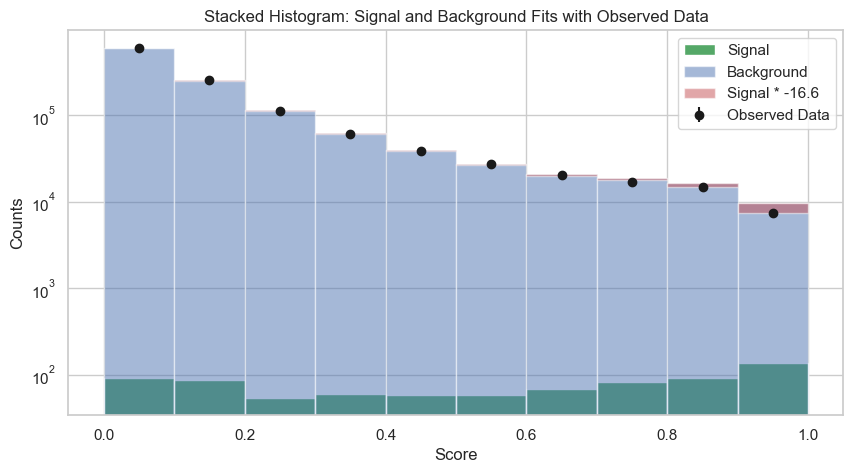

Validation Results:
---------- Results:
	mu_hat : -16.555878469821458
	delta_mu_hat : 1.6972925591269665
	p16 : -17.40452474938494
	p84 : -15.707232190257974


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.076e+07                 │              Nfcn = 526              │
│ EDM = 0.0278 (Goal: 0.0001)      │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───

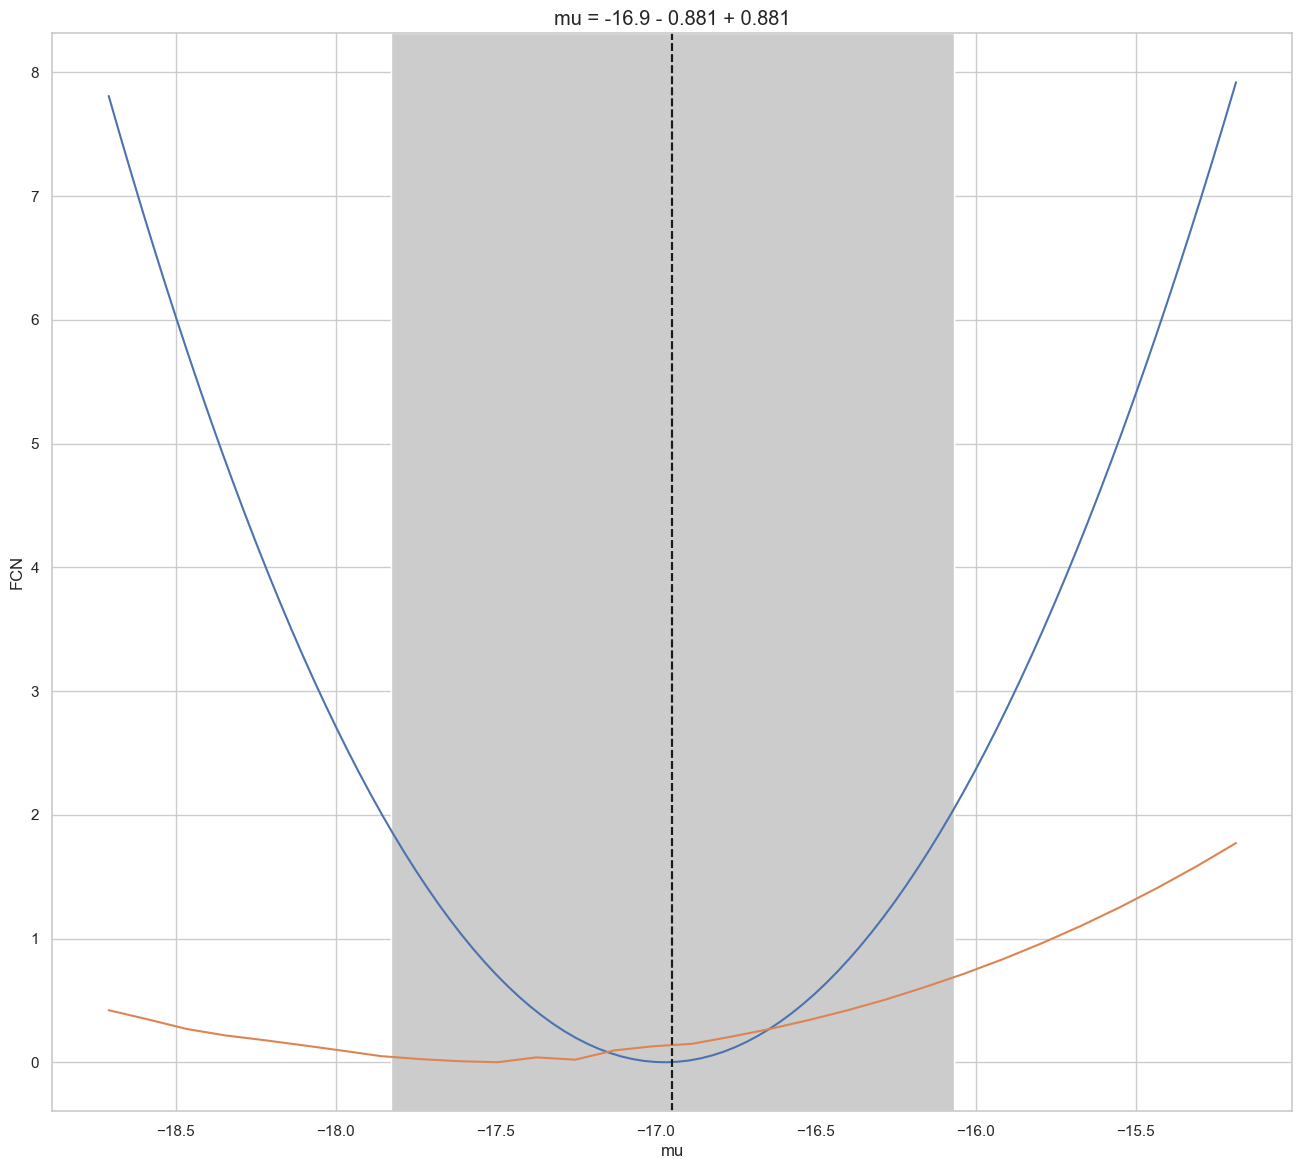

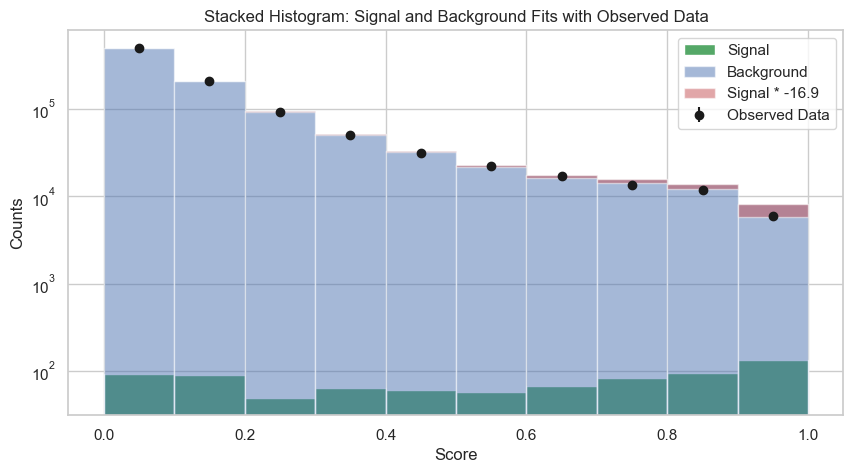

Holdout Results:
------- Results:
	mu_hat : -16.94790477793916
	delta_mu_hat : 1.7611676372660692
	p16 : -17.828488596572196
	p84 : -16.067320959306127




In [ ]:

# fit submission
ingestion.fit_submission()

In [ ]:

# load test set
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


In [ ]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
Test Results:  {'mu_hat': -8.74241508181906, 'delta_mu_hat': 2.8772769278191372, 'p16': -10.181053545728627, 'p84': -7.303776617909491}
[*] - mu_hat: -8.74241508181906 - delta_mu_hat: 2.8772769278191372 - p16: -10.181053545728627 - p84: -7.303776617909491
Test Results:  {'mu_hat': -16.259417954356223, 'delta_mu_hat': 3.2314004196224704, 'p16': -17.875118164167457, 'p84': -14.643717744544988}
[*] - mu_hat: -16.259417954356223 - delta_mu_hat: 3.2314004196224704 - p16: -17.875118164167457 - p84: -14.643717744544988
Test Results:  {'mu_hat': -58.88600939118094, 'delta_mu_hat': 3.60927577794211, 'p16': -60.690647280152, 'p84': -57.08137150220988}
[*] - mu_hat: -58.88600939118094 - delta_mu_hat: 3.60927577794211 - p16: -60.690647280152 - p84: -57.08137150220988
Test Results:  {'mu_hat': -2.9271647268643157, 'delta_mu_hat': 0.8076386834241459, 'p16': -3.3309840685763885, 'p84': -2.523345385152243}
[*] - mu_hat: -2.9271647268643157 - delta_mu_hat: 

In [ ]:
ingestion.compute_result()

[*] Saving ingestion result


In [ ]:

# save result
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('psuedo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [ ]:
from score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
score.load_ingestion_results(output_dir)

[*] Reading predictions
[✔]


[*] Computing scores
------------------
Set 0
------------------
MAE (avg): 35.8395031174966
RMSE (avg): 389.15796782379033
Interval: 4.092823827005874
Coverage: 0.0
Quantiles Score: -1.4095101130198944
------------------
Set 1
------------------
MAE (avg): 82.3190357815144
RMSE (avg): 3226.833314176613
Interval: 2.1573505031389444
Coverage: 0.0
Quantiles Score: -0.7693749327114513
------------------
Set 2
------------------
MAE (avg): 62.98269258107734
RMSE (avg): 1874.3177011320809
Interval: 3.3538529785117737
Coverage: 0.0
Quantiles Score: -1.2104386065607322
------------------
Set 3
------------------
MAE (avg): 45.911984881537684
RMSE (avg): 745.3182962567981
Interval: 2.685232229023461
Coverage: 0.0
Quantiles Score: -0.9881702121226322
------------------
Set 4
------------------
MAE (avg): 119.2226744600518
RMSE (avg): 6828.721844796673
Interval: 2.312990661495839
Coverage: 0.0
Quantiles Score: -0.8390042518123042


Overall Score
[*] --- RMSE: 2612.87
[*] --- MAE: 69.255
[*] --- 

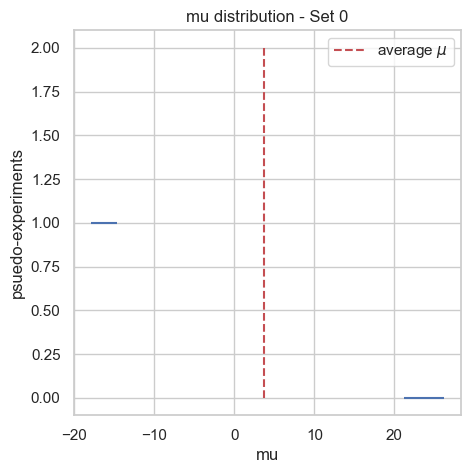

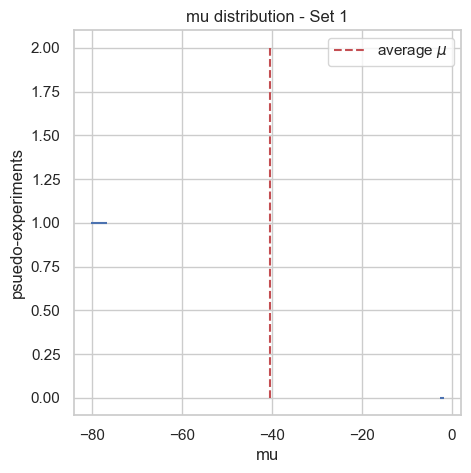

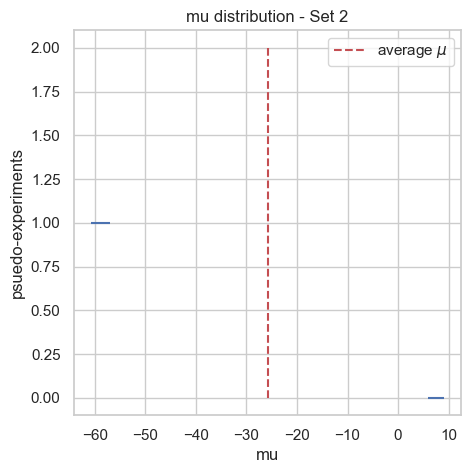

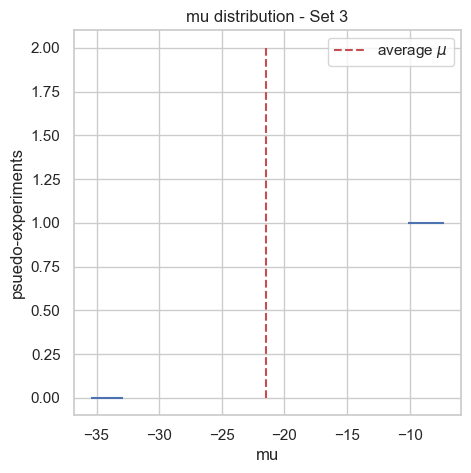

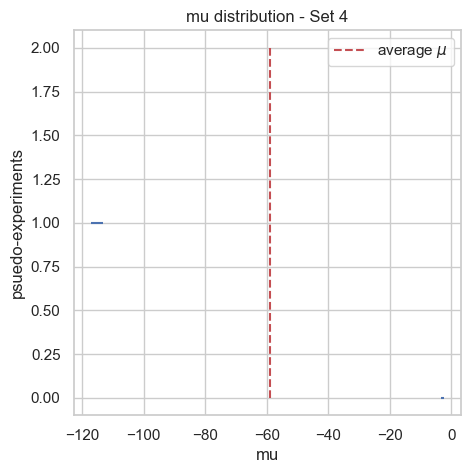

In [ ]:
# Compute Score
score.compute_scores(test_settings)

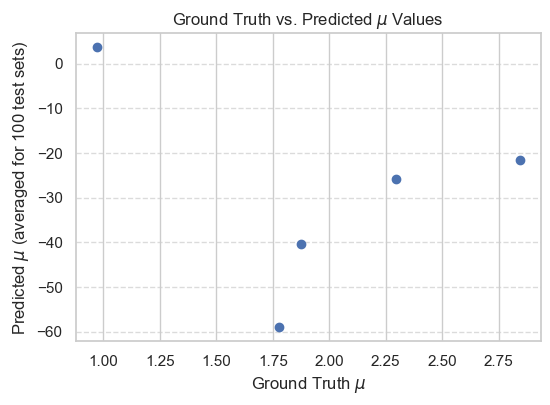

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

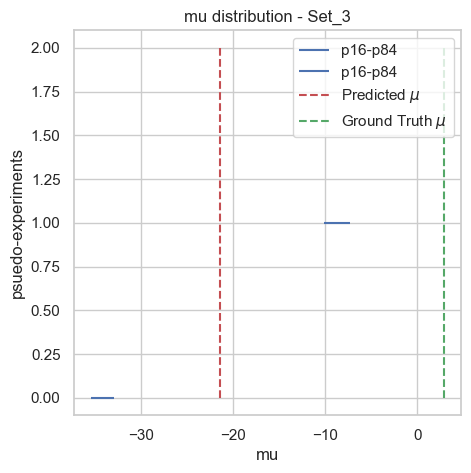

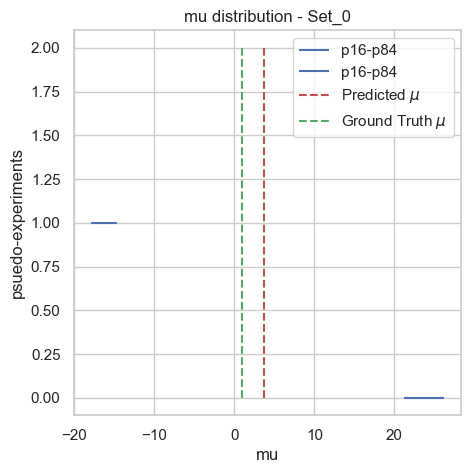

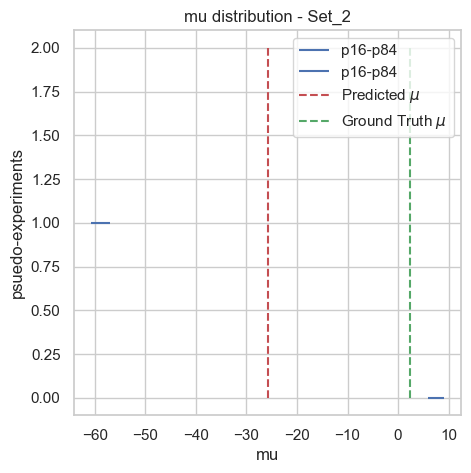

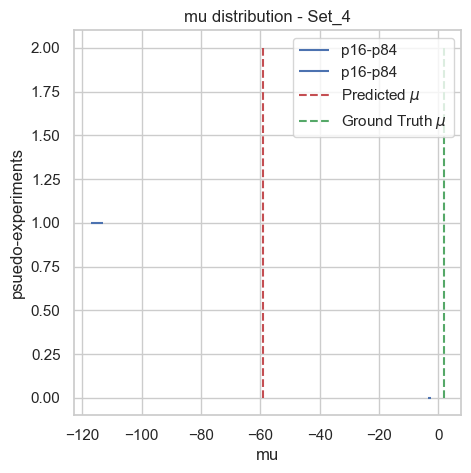

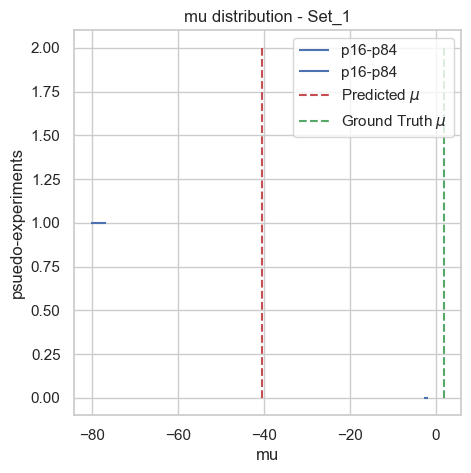

In [ ]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : HiggsML-code_submission_24-07-01-10-43.zip to the competition
You can find the zip file in `HEP-Challenge/
